In [7]:
import pandas as pd
import numpy as np

In [8]:
player_stats_df = pd.read_csv('player_stats_2.csv')

In [9]:
player_stats_df_old = pd.read_csv('player_stats.csv')

In [10]:
player_stats_df_old_main = player_stats_df_old[list(player_stats_df_old.columns)[1:]]

In [11]:
player_stats_df_main = player_stats_df[list(player_stats_df_old.columns)[1:]]

In [12]:
player_stats_df_old_main= player_stats_df_old_main.append(player_stats_df_main)

In [13]:
player_stats_df = player_stats_df_old_main

In [14]:
def to_float(x):
    try:
        return [float(i) for i in x]
    except:
        try:
            return [int(i) for i in x]
        except:
            return 'i'

player_stats_df['ShotsTotal'] = to_float(player_stats_df['ShotsTotal'])
player_stats_df['ShotOnTarget'] = to_float(player_stats_df['ShotOnTarget'])
player_stats_df['KeyPassTotal']  = to_float(player_stats_df['KeyPassTotal'])
player_stats_df['PassSuccessInMatch'] = to_float(player_stats_df['PassSuccessInMatch'])
player_stats_df['DuelAerialWon']   = to_float(player_stats_df['DuelAerialWon'])
player_stats_df['Touches'] = to_float(player_stats_df['Touches'])
player_stats_df['rating'] = to_float(player_stats_df['rating'])

In [15]:
def positions(i):
    if 'D' in i:
        return 'Defense'
    elif 'F' in i:
        return 'Forward'
    elif 'M' in i:
        return 'Mid'
    elif 'GK' in i:
        return 'GK'
    else:
        return 'Substitute'

In [16]:
def bandas(i):
    if i not in [',  GK  ', ',  Sub  '] and i in [',  AMC  ', ',  DC  ', ',  DMC  ', ',  FW  ', ',  MC  ', ',  MED  ', ',  MPC  ',]:
        return 'Centro'
    elif i not in [',  POR  ', ',  Sus  ']:
        return 'Bandas'
    else:
        return 'none'

In [17]:
player_stats_df['fieled_position'] = [positions(i) for i in player_stats_df['position']]

In [18]:
player_stats_df['bandas'] = [bandas(i) for i in player_stats_df['position']]

In [19]:
player_stats_df.head()

,player_name,game_id,field,team,position,ShotsTotal,ShotOnTarget,KeyPassTotal,PassSuccessInMatch,DuelAerialWon,Touches,rating,fieled_position,bandas
0,Matz Sels,https://whoscored.com//Matches/1376559/Live/Fr...,home,Strasbourg,", GK",0.0,0.0,0.0,0.6,2.0,3.0,i,GK,Bandas
1,Alexander Djiku,https://whoscored.com//Matches/1376559/Live/Fr...,home,Strasbourg,", DC",0.0,0.0,0.0,0.8,5.0,1.0,i,Defense,Centro
2,Stefan Mitrovic,https://whoscored.com//Matches/1376559/Live/Fr...,home,Strasbourg,", DC",0.0,0.0,0.0,0.9,3.0,7.0,i,Defense,Centro
3,Lamine Koné,https://whoscored.com//Matches/1376559/Live/Fr...,home,Strasbourg,", DC",1.0,0.0,1.0,0.7,2.0,9.0,i,Defense,Centro
4,Kenny Lala,https://whoscored.com//Matches/1376559/Live/Fr...,home,Strasbourg,", DMR",2.0,0.0,1.0,0.8,0.0,9.0,i,Defense,Bandas


## Grouping the data by positon and Sides or Center

We had the data at the Player/Game level, what we do in this is step is to summarise that data by Tema, the Postision (Deffense, Forward...) and the location in the fieled (Sides or Center). What I intend by doing this is, to classify each team based on the weight each position has in it and also by where the team locates its game (Sides or Center).

A classification like this one, will allow us to make a deeper analysis with the Games data that we also have, we will be able to see things such us (What happens when a team that weights most of its game in the midfieald and the center of the fieled plays against one that follows an opposite strategy?).

This Classification will also (hopefully), later on help our algorithm to find patterns in the data more easily.

In [20]:
grouped = player_stats_df.groupby(['team','fieled_position','bandas']).agg({'ShotsTotal':'sum','ShotOnTarget':'sum','KeyPassTotal':'sum',
                                                                          'PassSuccessInMatch':'mean','DuelAerialWon':'sum','Touches':'sum'}).reset_index()

In [21]:
grouped.head()

,team,fieled_position,bandas,ShotsTotal,ShotOnTarget,KeyPassTotal,PassSuccessInMatch,DuelAerialWon,Touches
0,AC Milan,Defense,Bandas,19.0,6.0,19.0,0.759091,24.0,140.0
1,AC Milan,Defense,Centro,13.0,0.0,12.0,0.830769,56.0,144.0
2,AC Milan,Forward,Bandas,29.0,15.0,29.0,0.758333,4.0,67.0
3,AC Milan,Forward,Centro,40.0,11.0,14.0,0.669231,37.0,46.0
4,AC Milan,GK,Bandas,0.0,0.0,0.0,0.681818,4.0,31.0


Since I do not have a huge number of dimension, I won't be performing dimetionality reduction. In this step we will be engeneering a feature: I will cluster the teams based on the metrics above using the basic but powerfull Kmeans.

In [22]:
fieled_position_group = grouped.groupby(['team','fieled_position']).agg({'ShotsTotal':'mean','ShotOnTarget':'mean','KeyPassTotal':'mean',
                                                                          'PassSuccessInMatch':'mean','DuelAerialWon':'mean','Touches':'mean'}).reset_index()


In [23]:
bandas_group = grouped.groupby(['team','bandas']).agg({'ShotsTotal':'mean','ShotOnTarget':'mean','KeyPassTotal':'mean',
                                                                          'PassSuccessInMatch':'mean','DuelAerialWon':'mean','Touches':'mean'}).reset_index()

In [24]:
bandas_group['ShotAcuracy'] = bandas_group['ShotOnTarget']/bandas_group['ShotsTotal']
fieled_position_group['ShotAcuracy'] = fieled_position_group['ShotOnTarget']/fieled_position_group['ShotsTotal']

In [25]:
bandas_group_stacked = bandas_group.set_index(['team','bandas']).unstack()
bandas_group_stacked.columns = [i[0]+"_"+i[1] for i in bandas_group_stacked.columns ]
bandas_group_stacked = bandas_group_stacked.reset_index()

In [26]:
fieled_position_stacked = fieled_position_group.set_index(['team','fieled_position']).unstack()
fieled_position_stacked.columns = [i[0]+"_"+i[1] for i in fieled_position_stacked.columns ]
fieled_position_stacked = fieled_position_stacked.reset_index()

In [27]:
final_df = fieled_position_stacked.merge(bandas_group_stacked, how = 'left').set_index(['team'])

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

standarized_df = num_pipeline.fit_transform(final_df)

In [29]:
from sklearn.cluster import KMeans

clusters = dict((i,0) for i in range(1,10))
for i in clusters.keys():
    kmeans = KMeans(n_clusters=i)
    y_pred = kmeans.fit_predict(standarized_df)
    clusters[i] += kmeans.inertia_

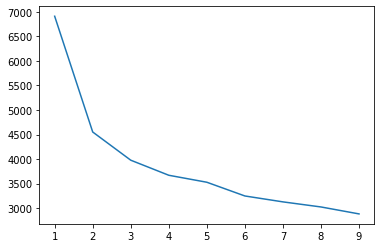

In [30]:
import matplotlib.pyplot as plt
x = list(clusters.keys())
y = list(clusters.values())
plt.plot(x,y)

#### From the elboy method we can deduct that the most efficient number of clusters is 3

In [92]:
k = 3
kmeans = KMeans(n_clusters=k)
final_df['final_classification'] = kmeans.fit_predict(standarized_df)

As we can see from the following table, there is a difference between the 3 groups in all of the metrics, which is a good indicator that we have clusterd the teams well

In [93]:
final_df.groupby('final_classification')[['ShotsTotal_Defense', 'ShotsTotal_Forward', 'ShotsTotal_GK',
       'ShotsTotal_Mid', 'ShotsTotal_Substitute', 'ShotOnTarget_Defense',
       'ShotOnTarget_Forward', 'ShotOnTarget_GK', 'ShotOnTarget_Mid',
       'ShotOnTarget_Substitute', 'KeyPassTotal_Defense',
       'KeyPassTotal_Forward', 'KeyPassTotal_GK', 'KeyPassTotal_Mid',
       'KeyPassTotal_Substitute', 'PassSuccessInMatch_Defense',
       'PassSuccessInMatch_Forward', 'PassSuccessInMatch_GK',
       'PassSuccessInMatch_Mid', 'PassSuccessInMatch_Substitute',
       'DuelAerialWon_Defense', 'DuelAerialWon_Forward', 'DuelAerialWon_GK',
       'DuelAerialWon_Mid', 'DuelAerialWon_Substitute', 'Touches_Defense',
       'Touches_Forward', 'Touches_GK', 'Touches_Mid', 'Touches_Substitute',
       'ShotsTotal_Bandas',
       'ShotsTotal_Centro', 'ShotOnTarget_Bandas', 'ShotOnTarget_Centro',
       'KeyPassTotal_Bandas', 'KeyPassTotal_Centro',
       'PassSuccessInMatch_Bandas', 'PassSuccessInMatch_Centro',
       'DuelAerialWon_Bandas', 'DuelAerialWon_Centro', 'Touches_Bandas',
       'Touches_Centro', 
       'final_classification']].mean()

,ShotsTotal_Defense,ShotsTotal_Forward,ShotsTotal_GK,ShotsTotal_Mid,ShotsTotal_Substitute,ShotOnTarget_Defense,ShotOnTarget_Forward,ShotOnTarget_GK,ShotOnTarget_Mid,ShotOnTarget_Substitute,...,ShotOnTarget_Centro,KeyPassTotal_Bandas,KeyPassTotal_Centro,PassSuccessInMatch_Bandas,PassSuccessInMatch_Centro,DuelAerialWon_Bandas,DuelAerialWon_Centro,Touches_Bandas,Touches_Centro,final_classification
final_classification,,,,,,,,,,,,,,,,,,,,,
0,18.338710,34.338710,0.032258,32.225806,19.322581,5.209677,15.209677,0.032258,11.000000,7.774194,...,12.376344,13.368280,22.150538,0.583361,0.741852,13.570430,47.290323,82.357527,136.107527,0
1,4.133333,7.113636,0.000000,7.700000,2.733333,1.333333,2.500000,0.000000,2.277778,0.844444,...,2.137037,2.774444,4.200000,0.508032,0.677988,4.318889,10.911111,18.237778,26.803704,1
2,10.846154,23.053846,0.015385,20.723077,11.184615,2.976923,8.846154,0.000000,6.630769,4.200000,...,7.230769,8.075385,13.400000,0.546176,0.716010,10.426667,36.805128,58.220000,88.902564,2


In [94]:
final_df[final_df.final_classification == 0].index

Index(['AC Milan', 'Atalanta', 'Bayer Leverkusen', 'Bologna', 'Bordeaux',
       'Borussia Dortmund', 'Borussia M.Gladbach', 'Brighton', 'Dijon',
       'Everton', 'Lazio', 'Lecce', 'Leicester', 'Manchester City',
       'Manchester United', 'Monaco', 'Nantes', 'Norwich',
       'Paris Saint-Germain', 'RasenBallsport Leipzig', 'Real Betis',
       'Real Madrid', 'Real Valladolid', 'Rennes', 'Roma', 'Sampdoria',
       'Sassuolo', 'Sevilla', 'Union Berlin', 'Villarreal',
       'Wolverhampton Wanderers'],
      dtype='object', name='team')

In [95]:
team_classsification_dic = dict((i,j) for (i,j) in zip(final_df.reset_index().team, final_df.final_classification))

In [96]:
final_df.to_csv("team_classification.csv",index = False)

## Bringing in and processing Games Data

In [97]:
games = pd.read_csv('games.csv')

In [98]:
games.shape

(634, 12)

In [99]:
games['home_team_classification'] = games['home_team'].map(team_classsification_dic)

In [100]:
games['away_team_classification'] = games['away_team'].map(team_classsification_dic)

In [101]:
formations = {'3-1-4-2':'Offensive',
 '3-4-1-2':'Offensive',
 '3-4-2-1':'Offensive',
 '3-4-3':'Offensive',
 '3-5-1-1':'Offensive',
 '3-5-2':'Offensive',
 '4-1-2-1-2':'Defensive',
 '4-1-3-2':'Defensive',
 '4-1-4-1':'Defensive',
 '4-2-2-2':'Defensive',
 '4-2-3-1':'Offensive',
 '4-3-1-2':'Defensive',
 '4-3-2-1':'Defensive',
 '4-3-3':'Offensive',
 '4-4-1-1':'Defensive',
 '4-4-2':'Defensive',
 '4-5-1':'Defensive',
 '5-3-2':'Defensive',
 '5-4-1':'Defensive'}

In [102]:
games['home_formation'] = games['home_team_formation'].map(formations)
games['away_formation'] = games['away_team_formation'].map(formations)

In [103]:
games_extra = games.copy()

In [104]:
import re

def goals(result):
    c = re.sub(':','',result)
    return list(re.sub(' ','',c))

def league(link):
    if 'Spain' in link:
        return 'La liga'
    if 'England' in link:
        return 'Premiere'
    if 'Italy' in link:
        return 'Serie A'
    if 'Portugal' in link:
        return 'Liga Nos'
    if 'France' in link:
        return 'League 1'
    if 'Germany' in link:
        return 'Bundesliga'

def winner(one,two):
    if one > two:
        return 1
    else:
        return 0
    
def odd(one,two):
    if one == two:
        return 1
    else:
        return 0
    
def cornersOver(corners):
    if corners > 9:
        return 1
    else:
        return 0

def cornersBelow(corners):
    if corners < 9:
        return 1
    else:
        return 0


def goalsOver(goals):
    if goals > 2.5:
        return 1
    else:
        return 0
    
def goalsBelow(goals):
    if goals < 2.5:
        return 1
    else:
        return 0
    

In [105]:
games_extra['half_time_home_goals'] = [int(goals(i)[0]) for i in games_extra['first_half_result']]
games_extra['half_time_away_goals'] = [int(goals(i)[1]) for i in games_extra['first_half_result']]
games_extra['full_time_home_goals'] = [int(goals(i)[0]) for i in games_extra['full_time_result']]
games_extra['full_time_away_goals'] = [int(goals(i)[1]) for i in games_extra['full_time_result']]
games_extra['half_time_goals'] = games_extra['half_time_home_goals'] + games_extra['half_time_away_goals']
games_extra['full_time_goals'] = games_extra['full_time_home_goals'] + games_extra['full_time_away_goals']
games_extra['league'] = [league(i) for i in games_extra['game_id']]
games_extra['total_corners'] = games_extra['away_team_corners'] + games_extra['home_team_corners']
games_extra['home_team_winner'] = [winner(i,j) for (i,j) in zip(games_extra.full_time_home_goals,games_extra.full_time_away_goals)]
games_extra['away_team_winner'] = [winner(i,j) for (i,j) in zip(games_extra.full_time_away_goals,games_extra.full_time_home_goals)]
games_extra['odd'] = [odd(i,j) for (i,j) in zip(games_extra.full_time_away_goals,games_extra.full_time_home_goals)]

In [106]:
games_extra = games_extra[games_extra['league'] != 'Liga Nos']

In [107]:
games_extra.dropna(inplace = True)

In [108]:
games_extra.shape

(445, 27)

In [109]:
to_drop = ['away_team','first_half_result','full_time_result','game_id','home_team']
games_extra.drop(to_drop, axis = 1, inplace = True)

In [110]:
games_extra = games_extra.iloc[0:,1:]

In [111]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(games_extra, test_size=0.20, random_state=42)

In [112]:
train_set['attendance'] = [int(re.sub(',','',i)) for i in train_set['attendance']]
test_set['attendance'] = [int(re.sub(',','',i)) for i in test_set['attendance']]

<ipython-input-112-c017b229e91c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['attendance'] = [int(re.sub(',','',i)) for i in train_set['attendance']]
<ipython-input-112-c017b229e91c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['attendance'] = [int(re.sub(',','',i)) for i in test_set['attendance']]


In [113]:
games_extra_lables = train_set[['away_team_corners','home_team_corners','half_time_home_goals','half_time_away_goals',
                        'full_time_home_goals','full_time_away_goals','half_time_goals','full_time_goals',
                        'total_corners','home_team_winner','away_team_winner','odd']]

In [114]:
games_extra_predictors = train_set.drop(['away_team_corners','home_team_corners','half_time_home_goals','half_time_away_goals',
                        'full_time_home_goals','full_time_away_goals','half_time_goals','full_time_goals',
                        'total_corners','home_team_winner','away_team_winner','odd','home_team_formation','away_team_formation','competition'], axis = 1)

In [115]:
games_extra_valid_lables = test_set[['away_team_corners','home_team_corners','half_time_home_goals','half_time_away_goals',
                        'full_time_home_goals','full_time_away_goals','half_time_goals','full_time_goals',
                        'total_corners','home_team_winner','away_team_winner','odd']]

In [116]:
games_extra_valid_pred = test_set.drop(['away_team_corners','home_team_corners','half_time_home_goals','half_time_away_goals',
                        'full_time_home_goals','full_time_away_goals','half_time_goals','full_time_goals',
                        'total_corners','home_team_winner','away_team_winner','odd','home_team_formation','away_team_formation','competition'], axis = 1)

In [117]:
games_extra_num = games_extra_predictors[["attendance"]]
games_extra_cat = games_extra_predictors.drop("attendance", axis = 1)

In [118]:
games_extra_num_valid = games_extra_valid_pred[["attendance"]]
games_extra_cat_valid = games_extra_valid_pred.drop("attendance", axis = 1)



In [119]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant", fill_value = 0)),
        ('std_scaler', StandardScaler()),
    ])

num_attribs = list(games_extra_num)
cat_attribs = list(games_extra_cat)

num_attribs_valid = list(games_extra_num_valid)
cat_attribs_valid = list(games_extra_cat_valid)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])
full_pipeline_valid = ColumnTransformer([
        ("num", num_pipeline, num_attribs_valid),
        ("cat", OneHotEncoder(), cat_attribs_valid),
    ])

X_train = full_pipeline.fit_transform(games_extra_predictors)

y_train = games_extra_lables[['half_time_goals','full_time_goals','total_corners']]

X_valid = full_pipeline_valid.fit_transform(games_extra_valid_pred)

y_valid = games_extra_valid_lables[['home_team_winner','away_team_winner','odd']]

## Let's go with the Fun Part

In [120]:
import tensorflow as tf
from tensorflow import keras

In [125]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[16]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [126]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [ ]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)
keras_reg.fit(X_train, y_train, epochs=23,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])
mse_test = keras_reg.score(X_valid, y_valid)
y_pred = keras_reg.predict(X_valid)

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3,4],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=23,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [177]:
rnd_search_cv.best_params_

{'learning_rate': 0.013336332619680218, 'n_hidden': 1, 'n_neurons': 49}

In [178]:
rnd_search_cv.best_score_

-21.45376968383789

In [408]:
import tensorflow as tf
from tensorflow import keras

In [185]:
def build_model(n_hidden=4, n_neurons=89, learning_rate=0.0017821762256654975, input_shape=[16]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(3))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer="sgd")
    return model

In [ ]:
model = keras.wrappers.scikit_learn.KerasRegressor(build_model)
model.fit(X_train, y_train, epochs=23,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])
mse_test = model.score(X_valid, y_valid)
y_pred = model.predict(X_valid)

In [187]:
def transformer():

    num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy="constant", fill_value = 0)),
            ('std_scaler', StandardScaler()),
        ])

    num_attribs = ['attendance']
    cat_attribs = ['away_formation','home_formation','home_team_classification','away_team_classification','league']

    full_pipeline = ColumnTransformer([
            ("num", num_pipeline, num_attribs),
            ("cat", OneHotEncoder(), cat_attribs),
        ])
    return full_pipeline

def inp(home, away):
    
    columns = ['attendance','away_formation','home_formation','home_team_classification','away_team_classification','league']
    dic = dict()
    l = list()
    for i in columns:
        if i == 'home_team_classification':
            dic[i] = float(team_classsification_dic[home])
        elif i == 'away_team_classification':
            dic[i] = float(team_classsification_dic[away])
        else:
            print(i)
            dic[i] = input()
    l.append(dic)
    df = pd.DataFrame(l)
    return df

def predictions(home,away, model):    
    to_pred = inp(home, away)
    final_model = model
    l = transformer().fit(games_extra_predictors)
    X_test_prepared = l.transform(to_pred)
    final_predictions = final_model.predict(X_test_prepared)
    return final_predictions



In [188]:
predictions('Arsenal', 'Chelsea', model)

attendance


 2000


away_formation


 Offensive


home_formation


 Offensive


league


 Premiere


/Users/eyuelmelese/miniconda3/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


array([1.3682883, 2.3676317, 8.898706 ], dtype=float32)

In [ ]:
model.save('/Users/eyuelmelese/Official Football')